In [4]:
import collections
import textwrap
import warnings
from functools import partial, reduce
from importlib import reload
from pathlib import Path
from pprint import pprint

import clip
import matplotlib.pyplot
import matplotlib.pyplot as plt
import medmnist
import numpy as np
import torch
import valuation
from opendataval.dataloader import DataFetcher
from opendataval.dataval import (
    DataOob,
    DataShapley,
    KNNShapley,
    LavaEvaluator,
    LeaveOneOut,
    RandomEvaluator,
    RobustVolumeShapley,
)
from opendataval.model import ClassifierSkLearnWrapper, RegressionSkLearnWrapper
from scipy.stats import kendalltau, pearsonr
from sklearn import random_projection
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import DistanceMetric, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer
from torchvision.transforms import Compose, ToPILImage
from tqdm.notebook import tqdm
from vendi_score import vendi

plt.rcParams["font.family"] = "serif"
fig_dir = Path("figures")

[KeOps] Warning : cuda was detected, but driver API could not be initialized. Switching to cpu only.


In [5]:
saved_embedding_path = Path("embeddings")

clean_med = {
    "bloodmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_BloodMNIST.pt"
    ),
    "breastmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_BreastMNIST.pt"
    ),
    "chestmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_ChestMNIST.pt"
    ),
    "dermamnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_DermaMNIST.pt"
    ),
    "pathmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_PathMNIST.pt"
    ),
    "retinamnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_RetinaMNIST.pt"
    ),
    "tissuemnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_TissueMNIST.pt"
    ),
    "organamnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_OrganAMNIST.pt"
    ),
}

noise_med = {
    "bloodmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_BloodMNIST_noise.pt"
    ),
    "breastmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_BreastMNIST_noise.pt"
    ),
    "chestmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_ChestMNIST_noise.pt"
    ),
    "dermamnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_DermaMNIST_noise.pt"
    ),
    "pathmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_PathMNIST_noise.pt"
    ),
    "retinamnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_RetinaMNIST_noise.pt"
    ),
    "tissuemnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_TissueMNIST_noise.pt"
    ),
}

In [95]:
sev_classes = {
    "pathmnist": [8, 7],
    "dermamnist": [4, 1, 0],
    "bloodmnist": [6, 4],
    "chestmnist": [6, 7],
    "breastmnist": [0],
    "tissuemnist": [2, 3],
    "retinamnist": [4, 3],
    "organamnist": [0, 9],
}

In [96]:
for k, v in medmnist.INFO.items():
    if k in sev_classes:
        print(k.upper(), [v["label"][str(a)] for a in sev_classes[k]])

PATHMNIST ['colorectal adenocarcinoma epithelium', 'cancer-associated stroma']
CHESTMNIST ['pneumonia', 'pneumothorax']
DERMAMNIST ['melanoma', 'basal cell carcinoma', 'actinic keratoses and intraepithelial carcinoma']
RETINAMNIST ['4', '3']
BREASTMNIST ['malignant']
BLOODMNIST ['neutrophil', 'lymphocyte']
TISSUEMNIST ['Glomerular endothelial cells', 'Interstitial endothelial cells']
ORGANAMNIST ['bladder', 'pancreas']


In [265]:
# d = "bloodmnist"
# d = "dermamnist"
# d = 'retinamnist'
# d = 'breastmnist'
d = "pathmnist"
# d = 'chestmnist'
# d = 'tissuemnist'
# d = 'organamnist'
x = clean_med[d]["embeddings"].float()
y = clean_med[d]["labels"]
# x = noise_med[d]['embeddings']
# y = noise_med[d]['labels']
# np.random.shuffle(y)

x_train = x[:1000]
y_train = y[:1000]

val_ratio = 0.1
num_val = round(val_ratio * x_train.shape[0])

x_val = x_train[:num_val]
y_val = y_train[:num_val]
x_train = x_train[num_val:]
y_train = y_train[num_val:]

x_test = x[-1000:]
y_test = y[-1000:]

classes = medmnist.INFO[d]["label"]
num_classes = len(classes)
if d == 'chestmnist':
    class_bincount = y.sum(0)
else:
    class_bincount = torch.bincount(y.flatten())
pprint(classes)

{'0': 'adipose',
 '1': 'background',
 '2': 'debris',
 '3': 'lymphocytes',
 '4': 'mucus',
 '5': 'smooth muscle',
 '6': 'normal colon mucosa',
 '7': 'cancer-associated stroma',
 '8': 'colorectal adenocarcinoma epithelium'}


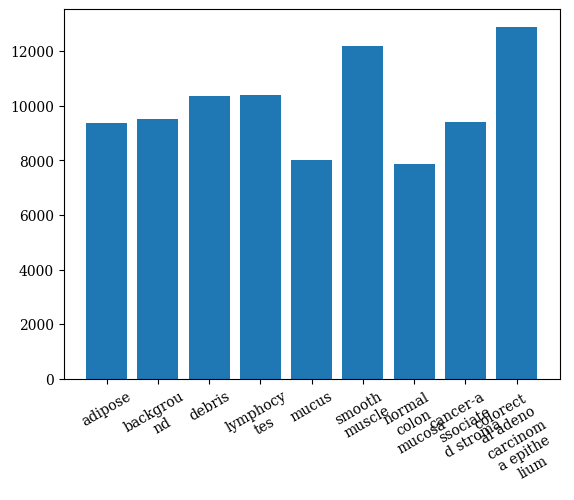

In [266]:
plt.figure()
plt.bar([textwrap.fill(v, width=8) for v in classes.values()], class_bincount)
plt.xticks(rotation=30)
plt.show()

In [267]:
def sample_dirichlet_by_class(
    x, y, num_sellers=10, num_samples=1000, add_to_alpha=1, min_samples=0
):
    y = y.squeeze().numpy()
    class_counts = np.bincount(y)
    class_prop = class_counts / class_counts.sum()
    class_weights = np.random.dirichlet(add_to_alpha + class_prop, size=num_sellers)
    sample_weights = {i: v[y] for i, v in enumerate(class_weights)}
    sample_weights = {k: v / v.sum() for k, v in sample_weights.items()}

    rang = np.arange(len(x))
    seller_indexes = {
        k: np.random.choice(rang, size=num_samples, replace=False, p=v)
        for k, v in sample_weights.items()
    }
    if min_samples > 0:
        new_index = []
        for c in np.unique(y):
            class_index = np.where(y == c)[0][:min_samples]
            new_index.extend(class_index)

        for k in seller_indexes:
            seller_indexes[k][: len(new_index)] = new_index

    return seller_indexes


# sample_dirichlet_by_class(x_test, y_test, min_samples=2)

In [268]:
def compute_utility(
    x_train,
    y_train,
    x_test,
    y_test,
    model=partial(LogisticRegression, max_iter=200),
    # utility=accuracy_score,
    utility=partial(f1_score, average="macro"),
    # utility=partial(f1_score, average=None),
):
    M = model()
    M.fit(x_train, y_train)
    y_pred = M.predict(x_test)
    return utility(y_test, y_pred)


# compute_utility(x_train, y_train, x_test, y_test)

In [269]:
x.shape

torch.Size([89996, 512])

In [278]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

if d == 'breastmnist':
    num_buyer = 50
    num_samples = 250
    print('breast')
elif d == 'dermamnist':
    num_buyer = 100
    num_samples = 1500
    print('derma')
elif d == 'pathmnist':
    num_buyer = 100
    num_samples = 1500 
    print('path')
elif d == 'retinamnist':
    num_buyer = 100
    num_samples = 500 
    print('retina')
elif d == 'Tissuemnist':
    num_buyer = 1500
    num_samples = 25000 
    print('tissue')
else:
    num_buyer = 500
    num_samples = 5000
    print('other')
    

x_dev, x_test, y_dev, y_test = train_test_split(x, y, test_size=0.3)
print(x_dev.shape, x_test.shape)

# cs = torch.tensor([4, 1, 0])
cs = torch.tensor(sev_classes[d])

if d == 'chestmnist':
    buyer_index = reduce(
        torch.logical_or, 
        torch.chunk(y_test[:, cs], len(cs), dim=1)
    ).flatten()
else:
    buyer_index = torch.isin(y_test.squeeze(), cs)
    
x_buyer = x_test[buyer_index][:num_buyer]
y_buyer = y_test[buyer_index][:num_buyer]
# x_buyer = x_test[:num_buyer]
# y_buyer = y_test[:num_buyer]

class_bc = []
vs = []
us = []
num_corr_class = []

for k, v in tqdm(
    sample_dirichlet_by_class(
        x_dev, y_dev, num_sellers=100, num_samples=num_samples, add_to_alpha=0.2, min_samples=1
    ).items()
):
    x_k = x_dev[v]
    y_k = y_dev.squeeze()[v]

    bc = np.bincount(y_k, minlength=num_classes)
    class_bc.append(bc)

    total = 0
    for c in cs:
        total += bc[c]
    num_corr_class.append(total)

    v = valuation.get_value(x_buyer, x_k)
    vs.append(v)

    u = compute_utility(
        # x_k,
        # y_k,
        # x_buyer,
        # y_buyer,
        x_k,
        torch.isin(y_k, cs),
        x_test,
        buyer_index,
    )

    us.append(u)
    print(k, bc, round(u, 2), {k: round(v_, 2) for k, v_ in v.items()})

path
torch.Size([62997, 512]) torch.Size([26999, 512])


  0%|          | 0/100 [00:00<?, ?it/s]

0 [273  33 403  17 204 299  11   2 258] 0.72 {'relevance': 0.5, 'l2': -0.0, 'cosine': 0.91, 'diversity': 0.4, 'volume': 71.79, 'vendi': 1.87, 'dispersion': 0.57}
1 [ 84   6   1 559  56 169  30  72 523] 0.76 {'relevance': 0.64, 'l2': -0.0, 'cosine': 0.96, 'diversity': 0.33, 'volume': 70.75, 'vendi': 1.8, 'dispersion': 0.53}
2 [  1   5 216 419   2 364  22 229 242] 0.78 {'relevance': 0.75, 'l2': -0.0, 'cosine': 0.98, 'diversity': 0.2, 'volume': 70.31, 'vendi': 1.74, 'dispersion': 0.51}
3 [692 500   1 213  70   1   1  21   1] 0.56 {'relevance': 0.36, 'l2': -0.01, 'cosine': 0.85, 'diversity': 0.31, 'volume': 70.42, 'vendi': 1.72, 'dispersion': 0.6}
4 [170 372  49  57  51   3   1   1 796] 0.67 {'relevance': 0.4, 'l2': -0.01, 'cosine': 0.93, 'diversity': 0.47, 'volume': 72.19, 'vendi': 1.97, 'dispersion': 0.61}
5 [  2   1  90  17  18 870   1   6 495] 0.66 {'relevance': 0.77, 'l2': -0.0, 'cosine': 0.97, 'diversity': 0.19, 'volume': 70.79, 'vendi': 1.8, 'dispersion': 0.51}
6 [ 15 202 447  64   

/tmp/ipykernel_7839/928604515.py:11: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(_x, _y, 10)


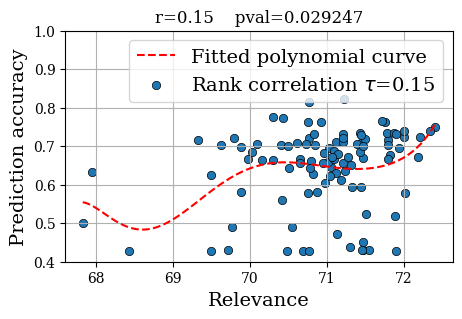

In [286]:
_x = [v["l2"] for v in vs]
_x = [v["cosine"] for v in vs]
_x = [v["relevance"] for v in vs]
_x = [v["dispersion"] for v in vs]
_x = [v["volume"] for v in vs]
# _x = [v["vendi"] for v in vs]
# _x = num_corr_class
_y = us

# Fit the polynomial (degree 2)
coefficients = np.polyfit(_x, _y, 10)

# Create a polynomial function with the fitted coefficients
polynomial = np.poly1d(coefficients)

# Generate x values for plotting the polynomial fit
x_fit = np.linspace(min(_x), max(_x), 100)
y_fit = polynomial(x_fit)

r = pearsonr(_x, _y)
r = kendalltau(_x, _y)

# Plotting
plt.figure(figsize=(5, 3))
plt.plot(x_fit, y_fit, color='red', label='Fitted polynomial curve', ls='--')

plt.scatter(
    _x, _y, 
    label = fr"Rank correlation $\tau$={round(r.statistic, 2)}",
    edgecolors='k',
    lw=0.5,
)

plt.title(f"r={round(r.statistic, 2)}    pval={round(r.pvalue, 6)}")
# plt.title(fr"$\tau$={round(r.statistic, 2)}", fontsize=14)
plt.grid()
# plt.xlabel('Data measurement', fontsize=14)
plt.xlabel('Relevance', fontsize=14)
# plt.xlabel('Number of data points with relevant labels', fontsize=14)
plt.ylabel('Prediction accuracy', fontsize=14)
plt.ylim(0.4, 1)
plt.legend(fontsize=14)
# plt.savefig(fig_dir / "correlation.eps", bbox_inches='tight')

# 